In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
# installing required packages
! pip install patchify
! pip install -U segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5 #segementation_models supports this version of keras
clear_output()

In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import glob
import shutil
import itertools
import imutils
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras

from patchify import patchify

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import MeanIoU
import random

#importing segmentation_models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Making directories for data flow to for training model
! mkdir 'data/' 'data/Train' 'data/Val' 'data/Train/images'  'data/Train/masks' 'data/Val/images'  'data/Val/masks'
! mkdir '256_patches/'  '256_patches/images' '256_patches/masks'
! mkdir '/content/256_patches/images_with_useful_info/' '/content/256_patches/images_with_useful_info/images/' '/content/256_patches/images_with_useful_info/masks/'

In [ ]:
#CHecking the directories are formed or not correctly
!apt-get install tree
clear_output()
!tree -d

.
├── 256_patches
│   ├── images
│   ├── images_with_useful_info
│   │   ├── images
│   │   └── masks
│   └── masks
├── data
│   ├── Train
│   │   ├── images
│   │   └── masks
│   └── Val
│       ├── images
│       └── masks
└── sample_data

14 directories


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive Data: \
Images: "/content/drive/MyDrive/Colab Notebooks/Garbage detection from drone images under Shishir Gaur Sir/Images" \
Image Maks: "/content/drive/MyDrive/Colab Notebooks/Garbage detection from drone images under Shishir Gaur Sir/Image Masks"\

To make the link accessible by collab we need to replace "open" with "uc" and the word "edit" with "export".

In [ ]:
IMG_PATH ="/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Data/Images/"
Mask_PATH = "/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Data/Masks/"

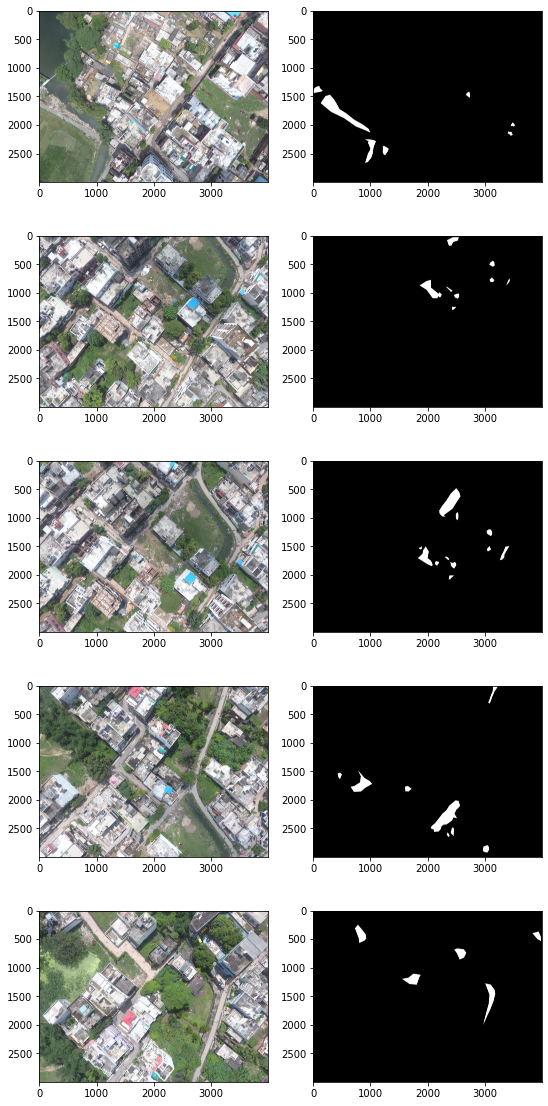

In [ ]:
#Checking images and masks
n_max_imgs = 5

plt.figure(figsize = (9, 20))
for n in range(n_max_imgs):
    image_path = os.listdir(IMG_PATH)[n]

    image = Image.open(IMG_PATH + image_path)
    image = np.array(image)

    label = Image.open(Mask_PATH + image_path)
    label = np.array(label)

    plt.subplot(n_max_imgs, 2, 2 * n + 1)
    plt.imshow(image)

    plt.subplot(n_max_imgs, 2, 2 * n + 2)
    plt.imshow(label)

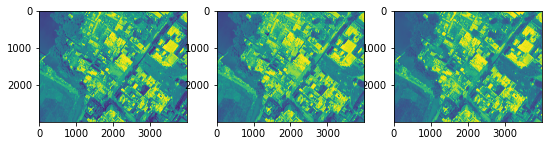

In [ ]:
temp_Img = cv2.imread(IMG_PATH + "/" +  os.listdir(IMG_PATH)[0])

#View each channel...

plt.figure(figsize = (9, 20))
plt.subplot(3, 3, 3)
plt.imshow(temp_Img[:,:, 0])
plt.subplot(3, 3, 1)
plt.imshow(temp_Img[:,:, 1])
plt.subplot(3, 3, 2)
plt.imshow(temp_Img[:,:, 2])

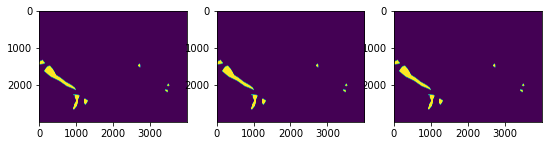

In [ ]:
temp_Img_Mask = cv2.imread(Mask_PATH + "/" +  os.listdir(Mask_PATH)[0])

#View each channel...

plt.figure(figsize = (9, 20))
plt.subplot(3, 3, 3)
plt.imshow(temp_Img_Mask[:,:, 0])
plt.subplot(3, 3, 1)
plt.imshow(temp_Img_Mask[:,:, 1])
plt.subplot(3, 3, 2)
plt.imshow(temp_Img_Mask[:,:, 2])

In [ ]:
img_dir = IMG_PATH
masks_dir = Mask_PATH

In [ ]:
# for CLASS in os.listdir(IMG_PATH):
#         IMG_NUM = len(os.listdir(IMG_PATH))
#         for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH)):
#             img = IMG_PATH + '/' + FILE_NAME
#             mask = Mask_PATH + '/' + FILE_NAME.split('.')[0]+ "_Mask.JPG"
#             shutil.copy(img, img_dir + '/' + FILE_NAME)
#             shutil.copy(mask, masks_dir + '/' + FILE_NAME.split('.')[0]+ "_Mask.JPG")

**Patchification** \
While making patches for image, we will take 256*256 patches. To cover the whole image we have to ensure that size of image should be (256 * m, 256 * n). \
It can be done by resizing or by cropping. \
For semantic segmentation we will avoid resizing the image.

3072 3840


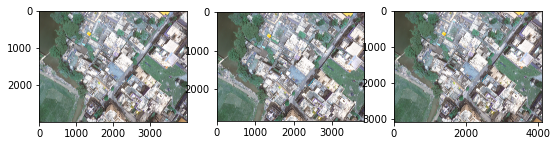

In [ ]:
# Resizing vs cropping
print ((3000//256) * 256 + 256, (4000//256) * 256 )
patch_size = 256

plt.figure(figsize = (9, 20))

temp = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Data/Images/A1')
plt.subplot(1, 3, 1)
plt.imshow(temp)

SIZE_X = (image.shape[1]//patch_size)*patch_size  #Nearest size divisible by our patch size
SIZE_Y = (image.shape[0]//patch_size)* patch_size
temp_crop = temp[0:SIZE_Y, 0:SIZE_X]
plt.subplot(1, 3, 2)
plt.imshow(temp_crop)

temp_resize = cv2.resize(temp, (4096, 3072))
plt.subplot(1, 3, 3)
plt.imshow(temp_resize)

In [ ]:
type(temp_crop)
patches_img = patchify(temp_crop, (256, 256, 3), step=256)
patches_img.shape
single_patch = patches_img[10, 0, :, : ][0]
type(single_patch)

numpy.ndarray

In [ ]:
#Patchifing images to shape 256 * 256 and storing in directory
images = os.listdir(img_dir)
for i, image_name in enumerate(images):
  image = cv2.imread(img_dir+ '/' + image_name, 1)
  image = image[0: SIZE_Y, 0: SIZE_X]
  patches_img = patchify(image, (256,256,3), step = 256) # step = 256 : no overlap when we take 256 steps
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i, j, :, : ][0]
      cv2.imwrite('/content/256_patches/images/' + "Patch_" + str(i) + '_' + str(j)+ '_' + image_name + ".JPG", single_patch_img)

In [ ]:
os.listdir(masks_dir)[0]
temp = cv2.imread( masks_dir + '/' + os.listdir(masks_dir)[0],1)
type(temp)

numpy.ndarray

In [ ]:
#Patchifing masks to shape 256 * 256 and storing in directory
masks = os.listdir(masks_dir)
for i, mask_name in enumerate(masks):
  mask = cv2.imread(masks_dir+ '/' + mask_name, 1)
  mask = mask[0: SIZE_Y, 0: SIZE_X]
  patches_mask = patchify(mask, (256,256,3), step = 256) # step = 256 : no overlap when we take 256 steps
  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
      single_patch_mask = patches_mask[i, j, :, : ][0]
      single_patch_mask = (single_patch_mask > 128) * 255
      cv2.imwrite('/content/256_patches/masks/' +  "Patch_" + str(i)+ '_' + str(j)+ '_' + mask_name + '.JPG', single_patch_mask)

NameError: ignored

In [ ]:
train_img_dir = "256_patches/images/"
train_mask_dir = "256_patches/masks/"

In [ ]:
print(len(os.listdir(train_img_dir)), len(os.listdir(train_mask_dir)))

14850 14850


In [ ]:
print(os.listdir(train_img_dir)[:5])
print(os.listdir(train_mask_dir)[:5])

['Patch_9_6_S38.JPG', 'Patch_5_4_A17.JPG', 'Patch_6_8_S34.JPG', 'Patch_4_12_S48.JPG', 'Patch_8_5_S52.JPG']
['Patch_9_6_S38.JPG', 'Patch_5_4_A17.JPG', 'Patch_6_8_S34.JPG', 'Patch_4_12_S48.JPG', 'Patch_8_5_S52.JPG']


In [ ]:
# os.listdir('/content/256_patches')

In [ ]:
# path = '/content/256_patches'
# for file_name in os.listdir(path):

#   file = path +"/" + file_name
#   if len(os.listdir(path)):
#     print('Deleting file:', file)
#     os.remove(file)

256_patches/images/Patch_6_4_S45.JPG
256_patches/masks/Patch_6_4_S45.JPG


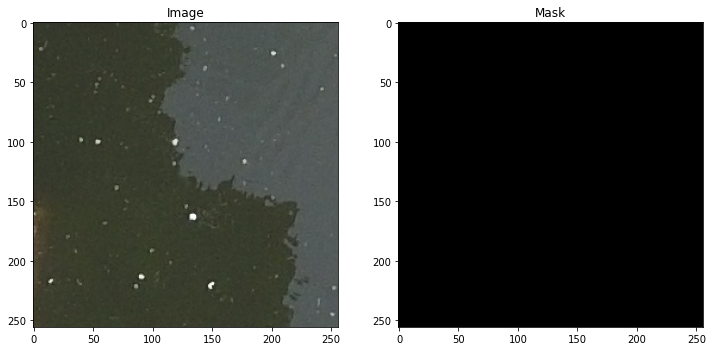

In [ ]:
# Randomly checking the images and masks
num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+os.listdir(train_img_dir)[img_num], 1)
print(train_img_dir+os.listdir(train_img_dir)[img_num])
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir +os.listdir(train_img_dir)[img_num] , 0)
print(train_mask_dir +os.listdir(train_img_dir)[img_num] )
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
# For emptying the directories.

# Directories = ["/content/TRAIN/Images", "/content/TRAIN/Masks", "/content/TEST/Images", "/content/TEST/Masks", "/content/VAL/Images","/content/VAL/Masks"]
# for path in Directories:
#   for file_name in os.listdir(path):

#     file = path +"/" + file_name
#     if len(os.listdir(path)):
#       print('Deleting file:', file)
#       os.remove(file)

In [ ]:
#Now, let us copy images and masks with real information to a new folder.
# real information = if mask has decent amount of labels other than 0.

useless=0  #Useless image counter
for img in range(num_images):   #Using t1_list as all lists are of same size
    img_name = os.listdir(train_img_dir)[img]
    mask_name = os.listdir(train_img_dir)[img]
    print("Now preparing image and masks number: ", img)

    temp_image=cv2.imread(train_img_dir+img_name, 1)

    temp_mask=cv2.imread(train_mask_dir+mask_name, 0)
    #temp_mask=temp_mask.astype(np.uint8)

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful area with labels that are not 0
        # print("Save Me")
        cv2.imwrite('/content/256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('/content/256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)

    else:
        # print("I am useless")
        useless +=1

print("Total useful images are: ", num_images - useless)  #20,075
print("Total useless images are: ", useless)

Streaming output truncated to the last 5000 lines.
Now preparing image and masks number:  9852
Now preparing image and masks number:  9853
Now preparing image and masks number:  9854
Now preparing image and masks number:  9855
Now preparing image and masks number:  9856
Now preparing image and masks number:  9857
Now preparing image and masks number:  9858
Now preparing image and masks number:  9859
Now preparing image and masks number:  9860
Now preparing image and masks number:  9861
Now preparing image and masks number:  9862
Now preparing image and masks number:  9863
Now preparing image and masks number:  9864
Now preparing image and masks number:  9865
Now preparing image and masks number:  9866
Now preparing image and masks number:  9867
Now preparing image and masks number:  9868
Now preparing image and masks number:  9869
Now preparing image and masks number:  9870
Now preparing image and masks number:  9871
Now preparing image and masks number:  9872
Now preparing image and m

In [ ]:
print(len(os.listdir('/content/256_patches/images_with_useful_info/images')), len(os.listdir('/content/256_patches/images_with_useful_info/masks/')))

981 981


In [ ]:
for CLASS in os.listdir('/content/256_patches/images_with_useful_info/images'):
        IMG_NUM = len(os.listdir('/content/256_patches/images_with_useful_info/images'))
        for (n, FILE_NAME) in enumerate(os.listdir('/content/256_patches/images_with_useful_info/images')):
            img = '/content/256_patches/images_with_useful_info/images/' + FILE_NAME
            mask =  '/content/256_patches/images_with_useful_info/masks/' + FILE_NAME
            if n < 0.90*IMG_NUM:
              shutil.copy(img, '/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Patch Images/Train/images/' + FILE_NAME)
              shutil.copy(mask, '/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Patch Images/Train/masks/' + FILE_NAME)
            else:
              shutil.copy(img, '/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Patch Images/Val/images/' + FILE_NAME)
              shutil.copy(mask, '/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Patch Images/Val/masks/' + FILE_NAME)

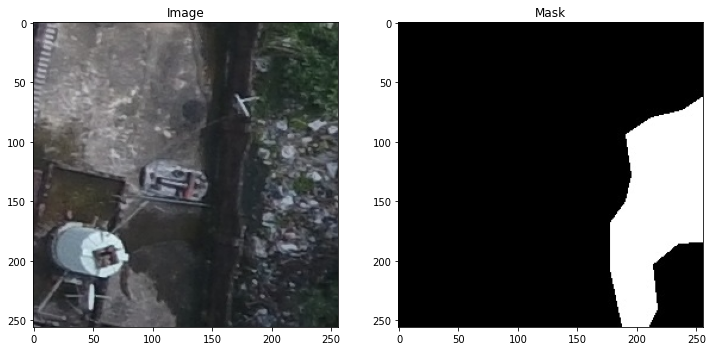

In [ ]:
#Get an understanding by looking at a few random images and masks

train_img_dir = '/content/data/Train/images/'
train_mask_dir = '/content/data/Train/masks/'

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+img_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
seed=24
batch_size= 16
n_classes=2

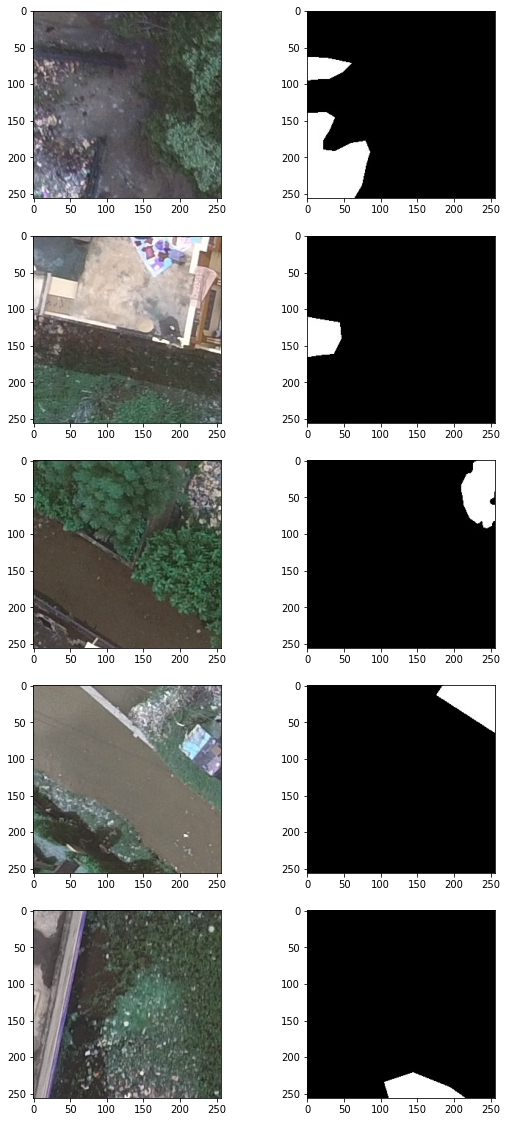

In [ ]:
plt.figure(figsize = (9, 20))
i = 0
for img in os.listdir('/content/data/Train/images/')[:5]:
  image = cv2.imread("/content/data/Train/images/" + img)
  mask = cv2.imread("/content/data/Train/masks/" + img)
  plt.subplot(5, 2, 2 * i + 1)
  plt.imshow(image)

  plt.subplot(5, 2, 2 * i + 2)
  plt.imshow(mask)
  i = i+1
  # print(image, mask)


In [ ]:
len(os.listdir('/content/data/Train/images'))

883

# Training The model (Failed)

In [ ]:
def data_loader(Path_dir):
    image_dataset = []
    for images in os.listdir(Path_dir):
        image = cv2.imread(Path_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return np.array(image_dataset)

In [ ]:
# /content/data/Train/images
X_TRAIN = data_loader("/content/data/Train/images")
y_TRAIN = data_loader("/content/data/Train/masks")
X_VAL = data_loader("/content/data/Val/images")
y_VAL = data_loader("/content/data/Val/masks")

In [ ]:
inputs = tf.keras.layers.Input((256,256,3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

In [ ]:
X_TRAIN = X_TRAIN/255.0
X_VAL = X_VAL/255.0
y_TRAIN = y_TRAIN/255.0
y_VAL = y_VAL/255.0

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
model.compile(optimizer='adam', loss=sm.losses.categorical_focal_dice_loss , metrics=[sm.metrics.iou_score])

In [ ]:
type(X_TRAIN[0][0][0][0])

In [ ]:
tf.config.experimental_run_functions_eagerly(False)

In [ ]:
history = model.fit(X_TRAIN, y_TRAIN,
                    batch_size = 64,
                    verbose = 1,
                    epochs = 50,
                    validation_data = (X_VAL, y_VAL),
                    shuffle = False
                    )

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



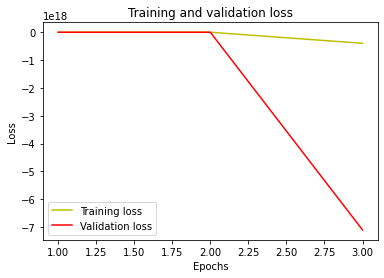

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

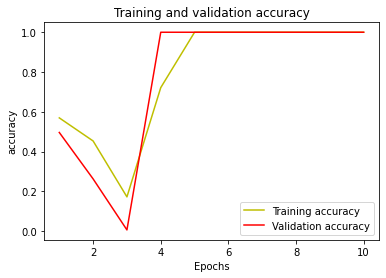

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
X_VAL[0].shape

(256, 256, 3)

4/4 [==============================] - 1s 87ms/step


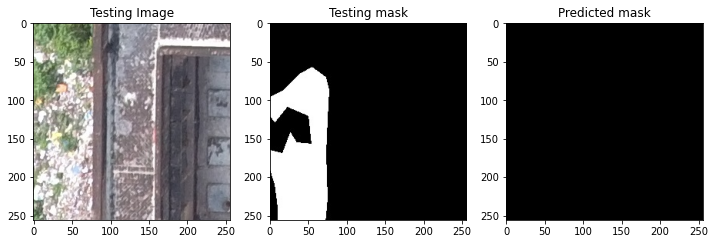

In [ ]:
Test_Pred = model.predict(X_VAL)
plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('Testing Image')
plt.imshow(X_VAL[0])
plt.subplot(2,3,2)
plt.title('Testing mask')
plt.imshow(y_VAL[0])
plt.subplot(2,3,3)
plt.title('Predicted mask')
plt.imshow(Test_Pred[3])

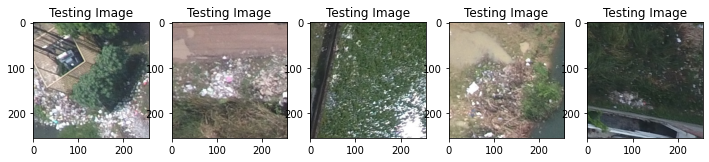

In [ ]:
plt.figure(figsize = (12,8))
for x in range(5):
  plt.subplot(1,5,x+1)
  plt.title('Testing Image')
  plt.imshow(X_VAL[x+10])

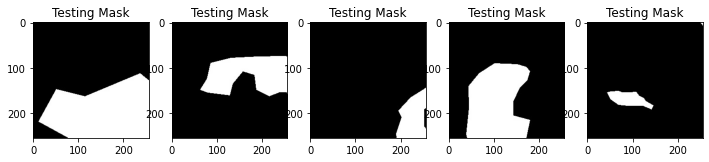

In [ ]:
plt.figure(figsize = (12,8))
for x in range(5):
  plt.subplot(1,5,x+1)
  plt.title('Testing Mask')
  plt.imshow(y_VAL[x+10])

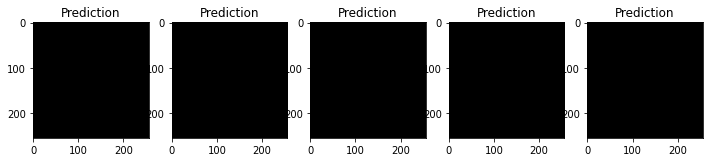

In [ ]:
plt.figure(figsize = (12,8))
for x in range(5):
  plt.subplot(1,5,x+1)
  plt.title('Prediction')
  plt.imshow(Test_Pred[x])